### 超参数的验证

神经网络中，除了权重和偏置等参数，**超参数(hyper-parameter)** 也经常出现。这里说的超参数是指，比如各层的神经元数量、batch大小、参数更新时的学习率或权值衰减等。如果这些超参数没有设置合适的值，模型的性能就会很差。虽然超参数的取值非常重要，但是在决定超参数的过程中一般会伴随很多的试错。

#### 验证数据
之前我们使用的数据集分为了**训练数据**（用于学习）和**测试数据**（用于评估泛化能力）。

要注意的是，**不能使用测试数据评估超参数的性能**，这一点非常重要，但也容易被忽视。这是因为**如果使用测试数据调整超参数，超参数的值会对测试数据发生过拟合**。换句话说，用测试数据确认超参数的“好坏”，就会导致超参数的值被调整为只拟合测试数据。

因此，调整超参数时，必须使用**验证数据(validation data)**，即专用于调整超参数的数据。

---

训练数据用于参数（权重和偏置）的学习，<br>
验证数据用于超参数的性能评估，<br>
为了确认泛化能力，要在最后使用（比较理想的是只用一次）测试数据。

---

根据不同的数据集，有的会事先分成 （训练数据、验证数据、测试数据），有的只分成（训练数据，测试数据），有的则不进行分隔。在这种情况下，用户需要自行进行分隔。如果是 MNIST 数据集，获得验证数据的最简单的方法就是从训练数据中事先分隔20%作为验证数据，代码如下。。

In [2]:
(x_train, t_train), (x_test, t_test) = load_mnist()

# 打乱训练数据
x_train, t_train = shuffle_dataset(x_train, t_train)

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate) # 分割的数据量

x_val = x_train[:validation_num]
t_val = x_train[:validation_num]
x_train = x_train[validation_num:]
t_train = x_train[validation_num:]

NameError: name 'load_mnist' is not defined

这里，分割数据前，先打乱了输入数据和监督标签。接下来，我们使用验证数据观察超参数的最优化方法。

#### 超参数的优化
进行超参数的优化时，逐渐缩小超参数的“好值”的存在非常重要。<br>
所谓逐渐缩小范围，是指一开始先大致设定一个范围，从这个范围中随机选出一个超参数（采样），用这个采样到的值进行识别精度的评估；<br>
然后，多次重复该操作，观察识别精度的结果，根据结果缩小超参数的“好值”的范围。<br>
通过重复这一操作，就可以逐渐确定超参数的合适范围。


超参数的范围只要“大致地指定”就可以了。所谓“大致地指定”，是指$0.001(10^-3)$到$1000(10^3)$这样，以“10的阶乘”的尺度指令范围（也表述为用对数尺度(log scale)指定）。

超参数的最优化中，要注意的是深度学习需要很长时间（比如，几天或几周）。因此，在超参数的搜索中，需要尽早放弃那些不符合逻辑的超参数。于是，在超参数的最优化中，减少学习的 epoch ,缩短一次评估所需的时间是一个不错的方法。

简单归纳一下超参数的最优化的内容，如下所示。
* **步骤0**<br>设定超参数的范围。
* **步骤1**<br>从设定的超参数范围中随机采样。
* **步骤2**<br>使用步骤1中采样到的超参数的值进行学习，通过验证数据评估识别精度（但是要将 epoch 设置得很小）。
* **步骤3**<br>重复步骤1和步骤2（100次等），根据它们的识别精度的结果，缩小超参数的范围。

反复进行上述操作，不断缩小超参数的范围，在缩小到一定程度时，从该范围中选出一个超参数的值。这就是进行超参数的最优化的一种方法。

---

上面介绍的超参数的最优化的方法是**实践性**的方法。这个方法与其说是科学的方法，不如说是实践者的经验的感觉。

如果需要更精炼的方法，可以使用**贝叶斯最优化**(Bayesian optimization)。贝叶斯优化运用以贝叶斯定理为中心的数学理论，能够更严密、高效地进行最优化。

---

#### 超参数最优化的实现
我们使用 MNIST 数据集进行超参数的最优化。这里我们将**学习率**和**控制权值衰减强度的系数**（下面称为“权值衰减系数”）这两个超参数的搜索问题作为对象。

实验中，权值衰减系数的初始范围为 $10^{-8}$ 到 $10^{-4}$ ，学习率的初始范围为 $10^{-6}$ 到 $10^{-2}$。此时超参数的随机采样代码如下。

In [4]:
import numpy as np

weigh_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)

像这样进行随机采样后，再使用那些值进行学习。之后，多次使用各种超参数的值重复进行学习，观察合乎逻辑的超参数在哪里。代码如下。

val acc:0.05 | lr:1.0472497081747791e-06, weight decay:1.1970429817336498e-07
val acc:0.07 | lr:4.983582525828059e-05, weight decay:4.087465117053228e-08
val acc:0.14 | lr:1.0768880788683853e-06, weight decay:1.026065336451934e-07
val acc:0.12 | lr:0.0007943925709801485, weight decay:1.7547282723936518e-06
val acc:0.13 | lr:8.727139631233445e-06, weight decay:5.171647687690424e-07
val acc:0.09 | lr:3.154371076932006e-05, weight decay:1.6993957520646972e-08
val acc:0.1 | lr:2.8438457772992772e-05, weight decay:2.2335044429446893e-05
val acc:0.11 | lr:9.62304482373385e-05, weight decay:1.5273742721472546e-06
val acc:0.1 | lr:0.00010655475837189838, weight decay:1.1243664732318264e-06
val acc:0.03 | lr:1.0167483262247567e-06, weight decay:2.046341751676849e-05
val acc:0.29 | lr:0.0023971219066952045, weight decay:9.032479281802583e-05
val acc:0.65 | lr:0.004645840605061452, weight decay:1.6212974225183073e-05
val acc:0.17 | lr:0.00033392063168040246, weight decay:2.1736342877852494e-05
va

Best-17(val acc:0.3) | lr:0.0016513589310901949, weight decay:2.6468986455464646e-08
Best-18(val acc:0.29) | lr:0.0023971219066952045, weight decay:9.032479281802583e-05
Best-19(val acc:0.29) | lr:0.0028387704262214037, weight decay:2.9606630204491574e-06
Best-20(val acc:0.27) | lr:0.0012431093328654453, weight decay:1.0199064696048709e-08


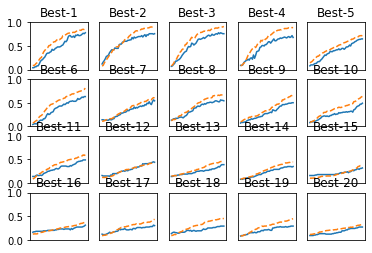

In [8]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了实现高速化，减少训练数据
x_train = x_train[:500]
t_train = t_train[:500]

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate) # 此处源码有问题
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 超参数的随机搜索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 指定搜索的超参数的范围===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 绘制图形========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


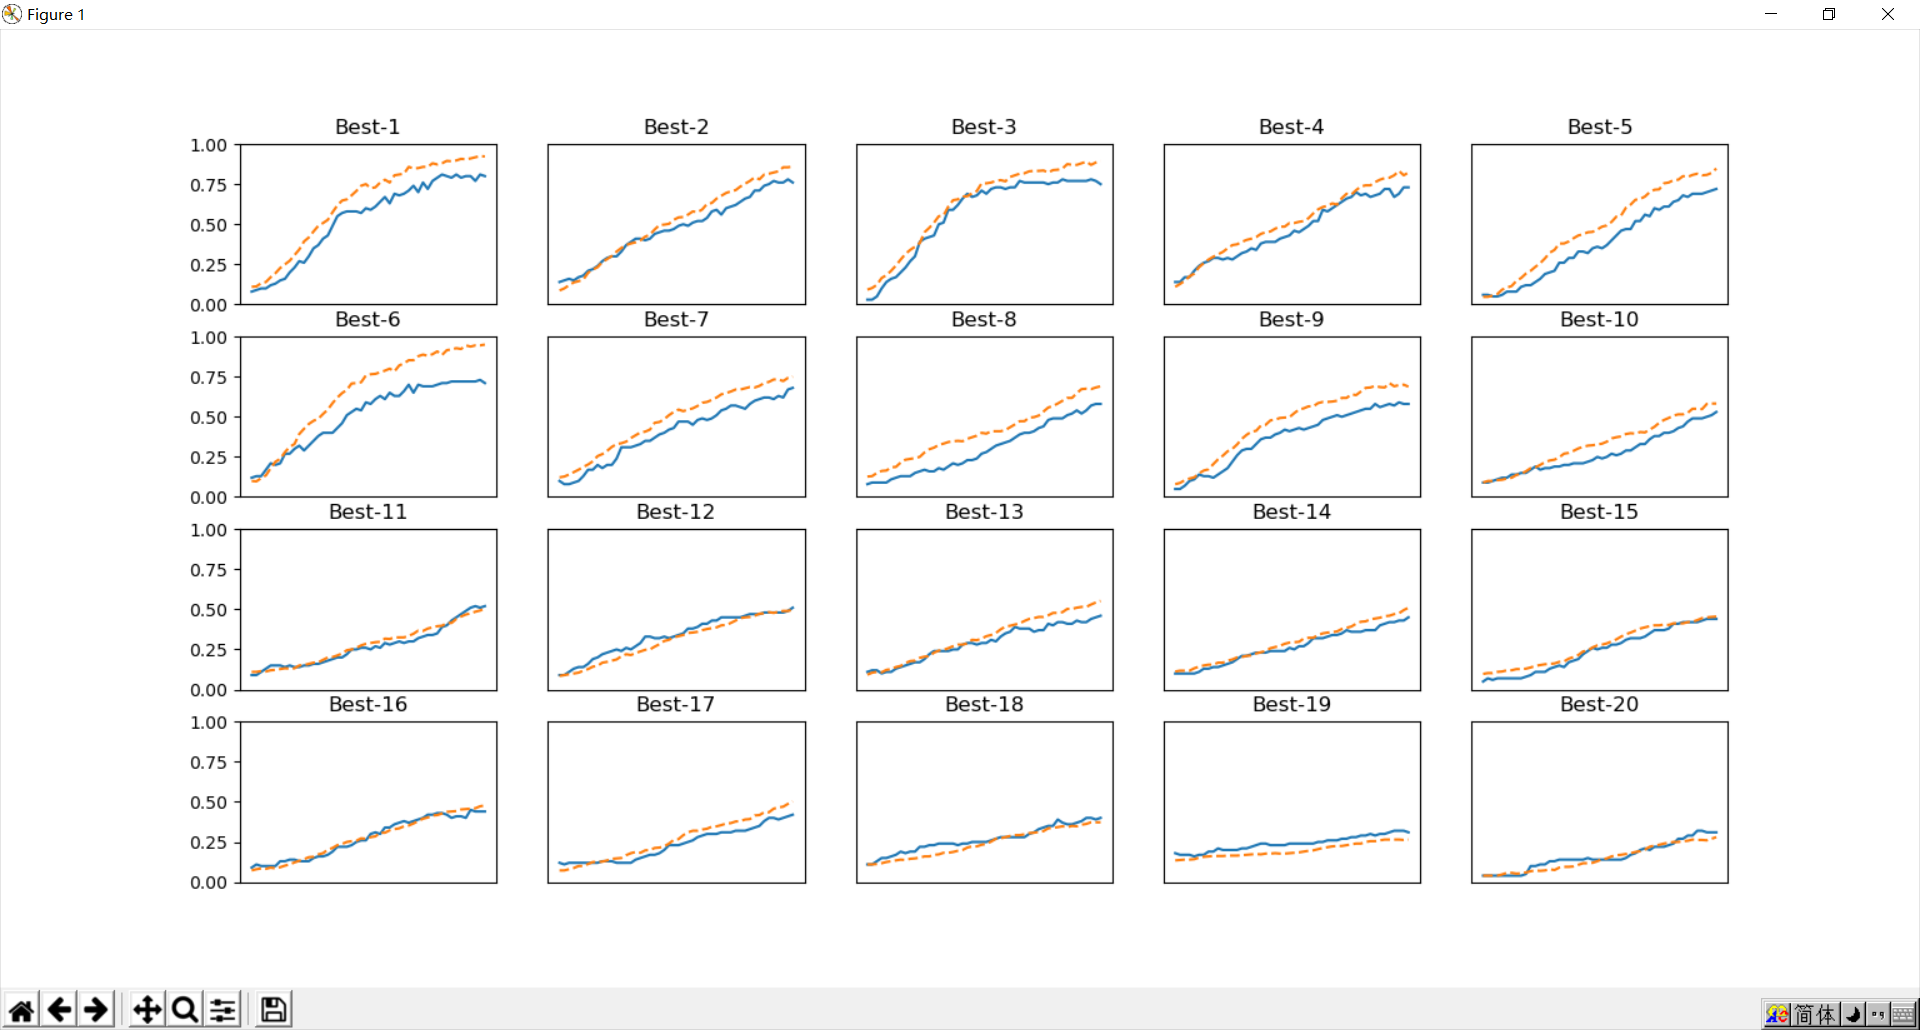

图中，按识别精度从高到低的顺序排列了验证数据的学习的变化。由图可知，直到“Best-5”左右，学习进行的都很顺利。因此，我们观察一下“Best-5”之前的超参数的值（学习率和权值衰减系数），结果如下所示。

```
Best-1(val acc:0.78) | lr:0.007055446751762949, weight decay:3.8405169813480086e-05
Best-2(val acc:0.76) | lr:0.009808403120263, weight decay:4.306895246780483e-05
Best-3(val acc:0.76) | lr:0.008781682079805012, weight decay:2.475354686842764e-06
Best-4(val acc:0.68) | lr:0.009202922709233629, weight decay:1.7466458750948372e-07
Best-5(val acc:0.65) | lr:0.004645840605061452, weight decay:1.6212974225183073e-05
```
从这个结果可以看出，学习率在 0.001 到 0.01、全职刷机减系数在 $10^{-8}$ 到 $10^{-6}$ 之间时，学习可以顺利进行。

像这样，观察可以使学习顺利进行的超参数的范围，从而缩小值的范围。然后在这个缩小的范围中重复相同的操作。这样就能缩小到合适的超参数的存在范围，然后在某个阶段，选择一个最终的超参数的值。

### 小结
本章我们介绍了神经网络的学习中的几个重要技巧。参数的更新方法、权重初始值的赋值方法、Batch Normalization、Dropout等，这些都是线代神经网络中不可或缺的技术。

* 参数的更新方法<br>除了 SGD 之外，还有 Momentum、AdaGrad、Adam等方法。
* 权重初始值的赋值方法对进行正确的学习非常重要。
* 作为权重初始值，Xavier、He初始值等比较有效。
* 通过使用 Batch Normalization，可以加速学习，并且使初始值变得简装。
* 抑制过拟合的正则化技术有权值衰减、Dropout等。
* 逐渐缩小“好值”存在的范围是搜索超参数的一个有效方法。
